# Tutorial: Understanding MetaDynamics Parameters/ Quantitative analysis of the results

Getting tutorial files using command line 
```
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/plumed_metad_params.ipynb
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/xvg_plot.py
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/funcs.py

```

In this tutorial we will try to understand how to optimally choose MetaD parameters and estimate the error of MetaD simulations.
Prerquisites:
- It is expected that you have accomplished plumed_intro.ipynb, plumed_bias.ipynb and plumed_metad_intro.ipyn tutorials.
- This tutorial is a contunuation of the plumed_meta_intro.ipynb tutorial.
- We expect all the files generated by plumed_meta_intro.ipynb tutorial to be present in the folder.

### Step 1. Simulating a high precision MetaD run as a reference and estimating its error and convergence.

First we will make a long MetaD run and use mild biasing parameters to minimize the biasing effects on the profile.

In [65]:
%%bash
for i in `seq 0 4`; do
cp MDProtocols/prod.mdp MDProtocols/prod_walkers$i.mdp
echo "ld-seed=$i" >> MDProtocols/prod_walkers$i.mdp
gmx grompp -f MDProtocols/prod_walkers$i.mdp -c equil.gro -p topol.top -o prod_walkers$i.tpr -r init_solv_ions.pdb -maxwarn 2 >/dev/null 2>&1

cp MDProtocols/prod1ns.mdp MDProtocols/prod1ns_walkers$i.mdp
echo "ld-seed=$i" >> MDProtocols/prod1ns_walkers$i.mdp
gmx grompp -f MDProtocols/prod1ns_walkers$i.mdp -c equil.gro -p topol.top -o prod1ns_walkers$i.tpr -r init_solv_ions.pdb -maxwarn 2 >/dev/null 2>&1

cp MDProtocols/prod2ns.mdp MDProtocols/prod2ns_walkers$i.mdp
echo "ld-seed=$i" >> MDProtocols/prod2ns_walkers$i.mdp
gmx grompp -f MDProtocols/prod2ns_walkers$i.mdp -c equil.gro -p topol.top -o prod2ns_walkers$i.tpr -r init_solv_ions.pdb -maxwarn 2 >/dev/null 2>&1

cp MDProtocols/prod10ns.mdp MDProtocols/prod10ns_walkers$i.mdp
echo "ld-seed=$i" >> MDProtocols/prod10ns_walkers$i.mdp
gmx grompp -f MDProtocols/prod10ns_walkers$i.mdp -c equil.gro -p topol.top -o prod10ns_walkers$i.tpr -r init_solv_ions.pdb -maxwarn 2 >/dev/null 2>&1

cp MDProtocols/prod100ns.mdp MDProtocols/prod100ns_walkers$i.mdp
echo "ld-seed=$i" >> MDProtocols/prod100ns_walkers$i.mdp
gmx grompp -f MDProtocols/prod100ns_walkers$i.mdp -c equil.gro -p topol.top -o prod100ns_walkers$i.tpr -r init_solv_ions.pdb -maxwarn 2 >/dev/null 2>&1

done

In [ ]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=1 PACE=200 FILE=HILLS_t1_02_1_200_100ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
#The next line runs MD, takes a lot of time, and better should be run from a terminal, or even a Tmux terminal.
#!mpirun -np 4 mdrun_mpi -deffnm prod100ns_walkers -plumed plumed_walkers.dat -multi 4 #2> /dev/null 



In [4]:
#As a result one gets a big HILLS_t1_02_1_200_100ns.dat file with a lot of data.
!ls -lh HILLS_t1_02_1_200_100ns.dat
!wc -l HILLS_t1_02_1_200_100ns.dat
#The file should have 4*50 000 000/200 lines = 1 million
#Here a link to the file for download https://www.dropbox.com/s/n4uf241idya8vz5/HILLS_t1_02_1_200_100ns.dat?dl=0
#!wget https://www.dropbox.com/s/n4uf241idya8vz5/HILLS_t1_02_1_200_100ns.dat?dl=0

-rw-rw-r-- 1 alexsha alexsha 111M Jan 21 08:19 HILLS_t1_02_1_200_100ns.dat
1000005 HILLS_t1_02_1_200_100ns.dat


In [49]:
!mkdir -p big_data
!plumed sum_hills --hills HILLS_t1_02_1_200_100ns.dat  --outfile big_data/sumhills_t1_02_1_200_100ns.dat  --mintozero  >/dev/null

Labels found: ['phi33', 'file.free', 'der_phi33']


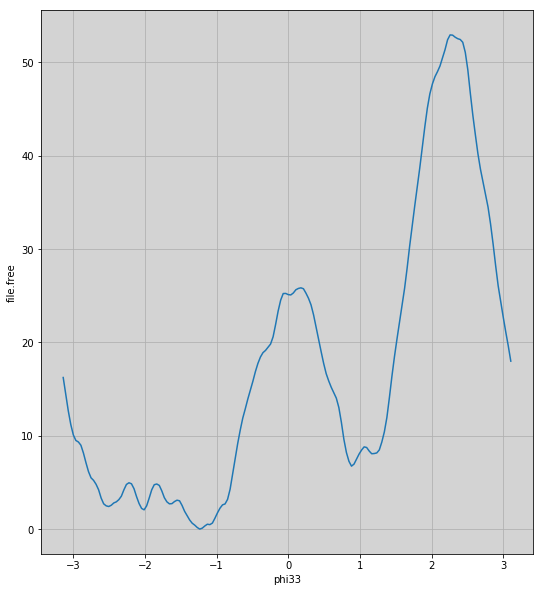

In [50]:
from funcs import plot_plumed
d=plot_plumed('big_data/sumhills_t1_02_1_200_100ns.dat',figsize=(10,10),col2plot=[1]) 

In [26]:
#We will output free energy profile every 100 000 steps
# Note from manual https://plumed.github.io/doc-v2.5/user-doc/html/sum_hills.html
# That stride outputs cumulative averages, to split in blocks use --nohistory keyword
!mkdir -p big_data
!plumed sum_hills --stride 100000 --hills HILLS_t1_02_1_200_100ns.dat --outfile big_data/sumhills_t1_02_1_200_100ns.dat --mintozero >/dev/null
!plumed sum_hills --stride 100000 --hills HILLS_t1_02_1_200_100ns.dat --outfile big_data/sumhills_t1_02_1_200_100ns_nohis.dat --mintozero --nohistory >/dev/null

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


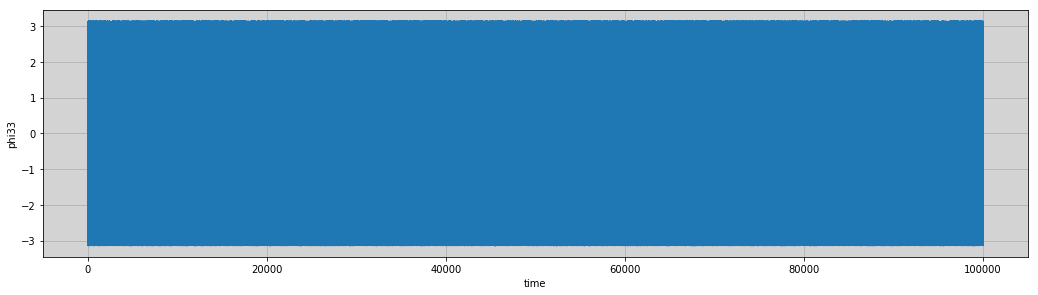

Text(0, 0.5, 'Energy, kJ/mol')

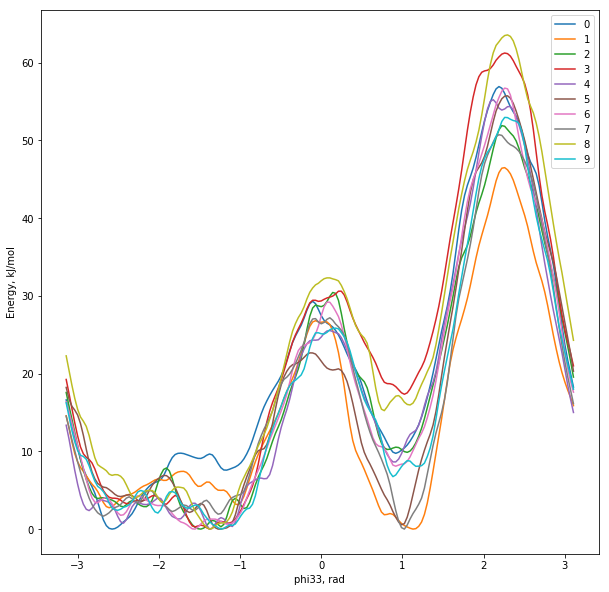

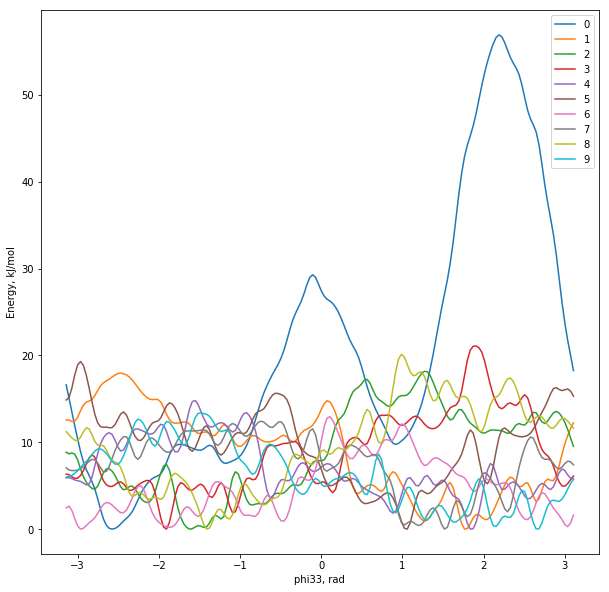

In [9]:
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Let's see the trajectory and understand sampling
d=plot_plumed('HILLS_t1_02_1_200_100ns.dat',figsize=(20,5),col2plot=[1])    

plt.figure(figsize=(10,10))
for i in range(10):
    data=plot_plumed('big_data/sumhills_t1_02_1_200_100ns.dat%d.dat'%i,plot=False,silent=True)
    plt.plot(data[:,0],data[:,1],label="%d"%i)
plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')

plt.figure(figsize=(10,10))
for i in range(10):
    data=plot_plumed('big_data/sumhills_t1_02_1_200_100ns_nohis.dat%d.dat'%i,plot=False,silent=True)
    plt.plot(data[:,0],data[:,1],label="%d"%i)
plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')


Let's understand the results:
- As explained in previous tutorial the MetaD potential fluctuates around the Free energy surface with an error of $\epsilon^2 \propto \frac{W/\tau}{D}$ 
- This is what we see on plots above.
- In theory the MetaD potential should be averaged out over the region where the dynamics has become diffusive to get the FES 
$$\bar F(\vec s) = - \frac{1}{t_\text{sim} - t_\text{diff}}
                          \int^{t_\text{sim}}_{t_\text{diff}} \!\!\!\!\!V_\text{bias}(\vec s, t)\, dt + C$$

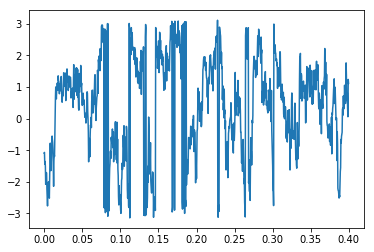

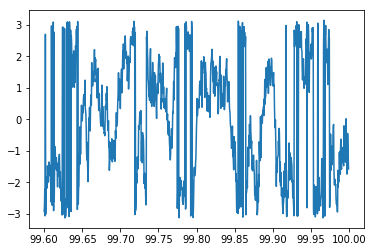

In [21]:
#Let's explore the diffusion
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#Beginning of trj
r=d[0:4000:4,1]
t=np.arange(0,100,0.0004)[0:1000]
plt.plot(t,r)

#End of trj
plt.figure()
r=d[-4000:-1:4,1]
t=np.arange(0,100,0.0004)[-1000:]
plt.plot(t,r)

- Clearly 1 ns and even 0.1 is enough to diffuse through all values of the angle.
- Let's do classical convergence analysis with 0.1 ns step.

In [32]:
#We will output free energy profile every 0.1 ns
# That stride outputs cumulative averages, to split in blocks use --nohistory keyword
!mkdir -p big_data
!plumed sum_hills --stride 1000 --hills HILLS_t1_02_1_200_100ns.dat --outfile big_data/sumhills_t1_02_1_200_100ns.dat >/dev/null

Text(0, 0.5, 'Energy, kJ/mol')

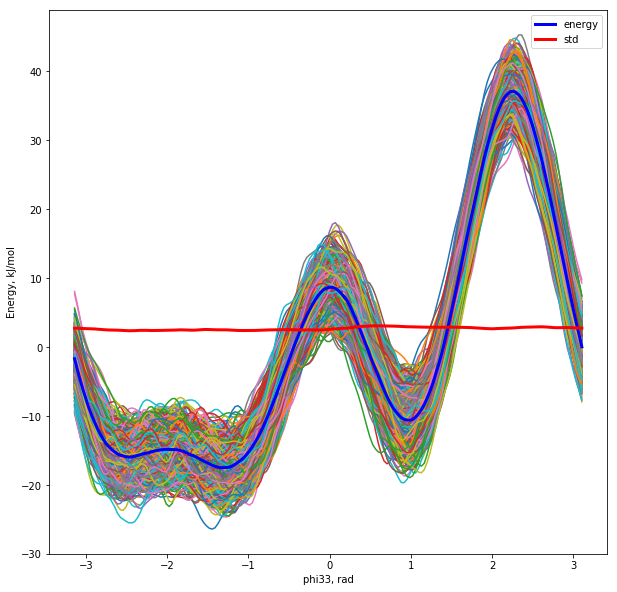

In [31]:
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
sum_df=pd.DataFrame()

plt.figure(figsize=(10,10))
for i in range(1000):
    data=plot_plumed('big_data/sumhills_t1_02_1_200_100ns.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
    plt.plot(df['angle'],df['energy'],label='_nolegend_')
df_avr=sum_df.groupby('angle', as_index=False).energy.mean()
std=sum_df.groupby('angle').energy.std()
plt.plot(df_avr['angle'],df_avr['energy'],'b-',linewidth=3)
plt.plot(std,'r-',linewidth=3,label='std')
plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')


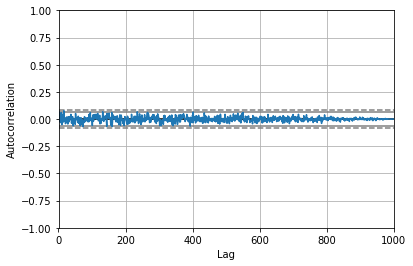

In [32]:
#Let's estimate correlations.
#sum_df.iloc[0]
data=sum_df.loc[sum_df['angle']<-3.141592,'energy']
#.autocorr()
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data)
#Correlations are below 99% interval, as seen on the plot.

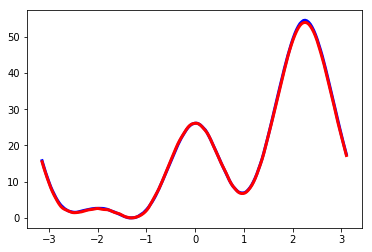

In [45]:
#However, we need to make sure there was no drift.
#Let's calculate profiles for the first part of the trajectory, 10 ns, or even less
df_avr_1=sum_df.loc[sum_df['Time']<100].groupby('angle', as_index=False).energy.mean()
df_avr['energy']=df_avr['energy']-df_avr['energy'].min()
df_avr_1['energy']=df_avr_1['energy']-df_avr_1['energy'].min()
plt.plot(df_avr['angle'],df_avr['energy'],'b-',linewidth=3)
plt.plot(df_avr_1['angle'],df_avr_1['energy'],'r-',linewidth=3)

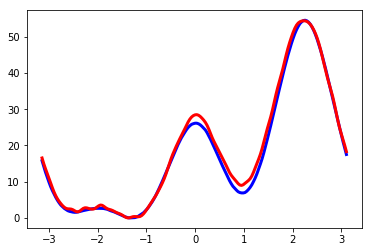

In [77]:
#However, we need to make sure there was no drift.
#Let's calculate profiles for the first part of the trajectory, 1 ns, or even less
df_avr_1=sum_df.loc[sum_df['Time']<10].groupby('angle', as_index=False).energy.mean()
df_avr['energy']=df_avr['energy']-df_avr['energy'].min()
df_avr_1['energy']=df_avr_1['energy']-df_avr_1['energy'].min()
plt.plot(df_avr['angle'],df_avr['energy'],'b-',linewidth=3)
plt.plot(df_avr_1['angle'],df_avr_1['energy'],'r-',linewidth=3)

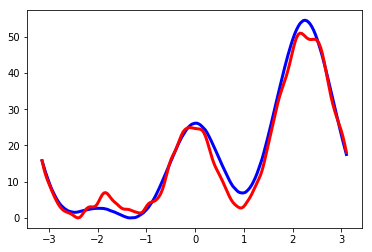

In [79]:
#However, we need to make sure there was no drift.
#Let's calculate profiles for the first part of the trajectory, 0.1 ns,
df_avr_1=sum_df.loc[sum_df['Time']<1].groupby('angle', as_index=False).energy.mean()
df_avr['energy']=df_avr['energy']-df_avr['energy'].min()
df_avr_1['energy']=df_avr_1['energy']-df_avr_1['energy'].min()
plt.plot(df_avr['angle'],df_avr['energy'],'b-',linewidth=3)
plt.plot(df_avr_1['angle'],df_avr_1['energy'],'r-',linewidth=3)

Text(0, 0.5, 'Energy, kJ/mol')

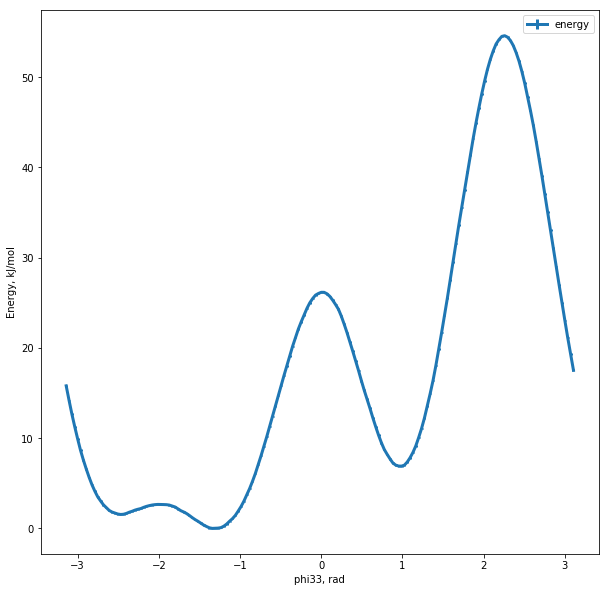

In [33]:
#We can draw and save Free energy with error estimates.
#we'll devide std by sqrt(N)
df_avr['energy']=df_avr['energy']-df_avr['energy'].min()
plt.figure(figsize=(10,10))
plt.errorbar(df_avr['angle'],df_avr['energy'],yerr=std.values/(1000**0.5),linewidth=3)
plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')

In [53]:
### We will save the reference profile
df_avr['StdErr']=std.values/(1000**0.5)
df_avr['StdDev']=std.values
df_avr.to_csv('reference_FEP_phi33.cvs')

In [92]:
#Here is the magnitude of errors in kJ/mol, kT is 2.5 kJ/mol - much less that kT, several % of kT!
#We will also reread it from file here
import pandas as pd
df_avr=pd.read_csv('reference_FEP_phi33.cvs',index_col=0)
df_avr

,angle,energy,StdErr,StdDev
0,-3.141593,15.794159,0.086750,2.743277
1,-3.106294,14.186171,0.086404,2.732320
2,-3.070995,12.646564,0.085703,2.710179
3,-3.035696,11.243614,0.084983,2.687402
4,-3.000397,9.916284,0.084499,2.672100
5,-2.965099,8.656411,0.084153,2.661159
6,-2.929800,7.569201,0.083733,2.647869
7,-2.894501,6.583008,0.083104,2.627987
8,-2.859202,5.660616,0.082170,2.598437
9,-2.823904,4.831350,0.081005,2.561608


## Step 2. Let's now look at the evolution of our original run.
Partially, we have already looked at the evolution of the avarage MetaD potential above - even 1 ns - provides us with a good estimate of the true FEP if we average it out.
Let's look again at the instantaneous one.

Text(0, 0.5, 'Energy, kJ/mol')

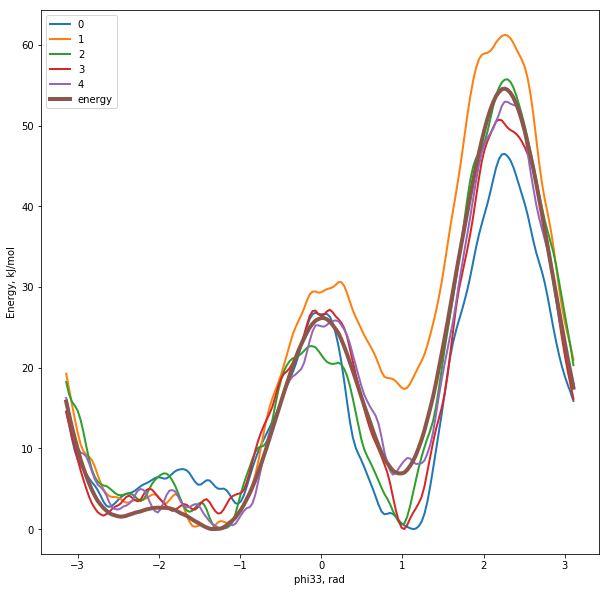

In [50]:
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!mkdir -p big_data
!plumed sum_hills --stride 200000 --hills HILLS_t1_02_1_200_100ns.dat --outfile big_data/sumhills_t1_02_1_200_100ns.dat --mintozero >/dev/null

plt.figure(figsize=(10,10))
for i in range(5):
    data=plot_plumed('big_data/sumhills_t1_02_1_200_100ns.dat%d.dat'%i,plot=False,silent=True)
    plt.plot(data[:,0],data[:,1],label="%d"%i,linewidth=2)
plt.plot(df_avr['angle'],df_avr['energy'],linewidth=4)
plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')



There are two problems:
- The fluctuation of the potential itself
- The bias introduced by setting minimum to zero.


Text(0, 0.5, 'Energy, kJ/mol')

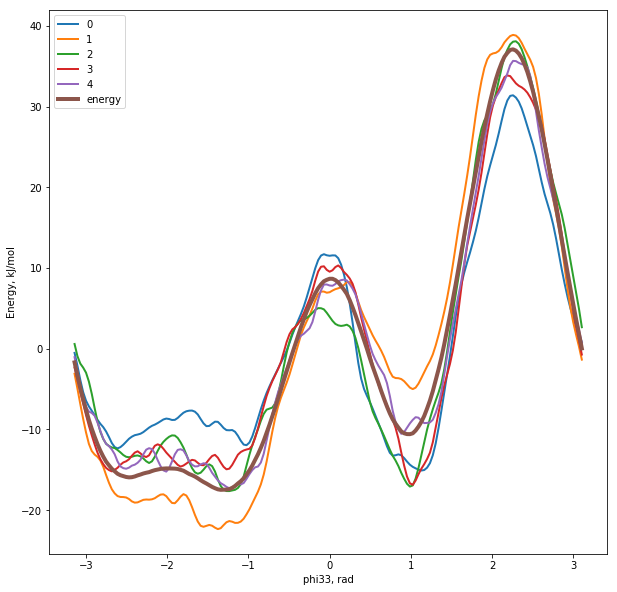

In [51]:
#Let's set zero to average
import numpy as np
plt.figure(figsize=(10,10))
for i in range(5):
    data=plot_plumed('big_data/sumhills_t1_02_1_200_100ns.dat%d.dat'%i,plot=False,silent=True)
    data[:,1]=data[:,1]-np.mean(data[:,1])
    plt.plot(data[:,0],data[:,1],label="%d"%i,linewidth=2)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),linewidth=4)
plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')



Fluctuations are clearly afecting the instantaneous MetaD potential. 

## Step 3. Exploring various MetaD parameters and the speed of convergence.

In the original run we were bombing our system with 1 kJ every 0.4 ps, and probably even more due to multiple walkers. The potential fluctuations were around 3 kJ/mol.
This value is around the flux of energy per 1 ps. According to the formula $\epsilon^2 \propto \frac{W/\tau}{D}$ to reduce error to 0.3 kJ/mol, we'll need to reduce the flux by 100!
On the other hand we have seen, that 4 ns of combined time is enough to get a good profile.
Alternatively we can bomb our system even at a higher rate and average out.

### Simulating with a small perurbation 100 less than the original for 10 ns with 4 walkers: decreasing deposition rate

We'll have to use 20 000 steps deposition rate, which is 40 ps. We will deposit only 1000 gaussians in 250 steps.

In [68]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=1 PACE=20000 FILE=HILLS_t1_02_1_20000_10ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
#The next line runs MD, takes a lot of time, and better should be run from a terminal, or even a Tmux terminal.
#!mpirun -np 4 mdrun_mpi -deffnm prod10ns_walkers -plumed plumed_walkers.dat -multi 4 #2> /dev/null 


Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


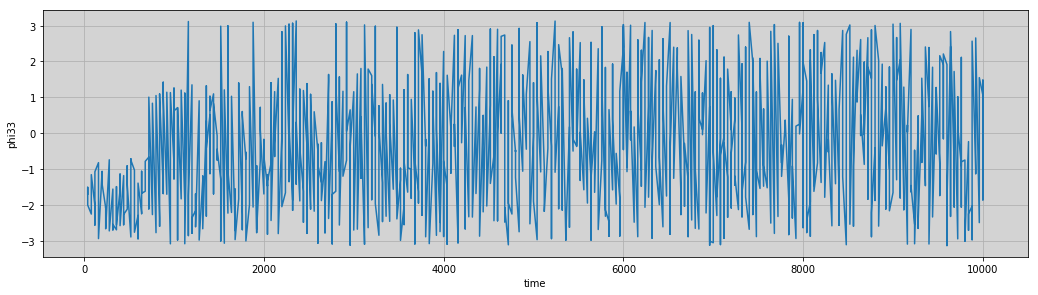

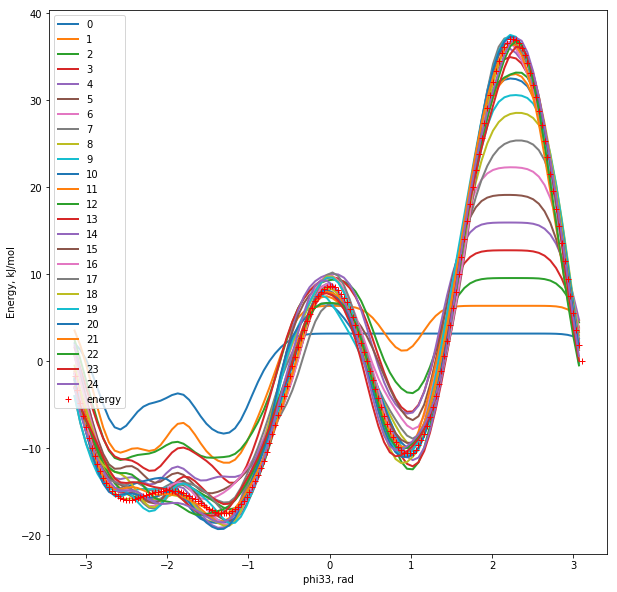

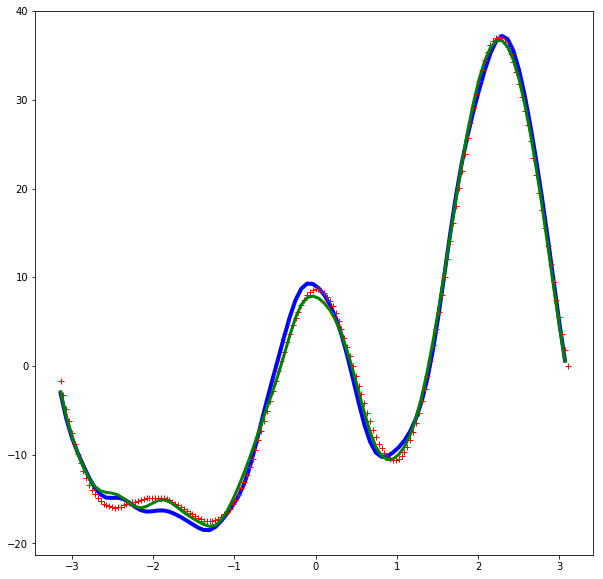

In [98]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!mkdir -p big_data
!plumed sum_hills --stride 40  --hills HILLS_t1_02_1_20000_10ns.dat --outfile big_data/sumhills_t1_02_1_20000_10ns.dat --mintozero >/dev/null
d=plot_plumed('HILLS_t1_02_1_20000_10ns.dat',figsize=(20,5),col2plot=[1]) 


sum_df=pd.DataFrame()


plt.figure(figsize=(10,10))
for i in range(25):
    data=plot_plumed('big_data/sumhills_t1_02_1_20000_10ns.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
    plt.plot(df['angle'],df['energy'],label="%d"%i,linewidth=2)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=3)
# plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].min(),'r+',linewidth=4)


plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')
plt.figure(figsize=(10,10))
plt.plot(df['angle'],df['energy'],'b-',linewidth=4)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=4)

df_avr_n=sum_df.loc[sum_df['Time']>15].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n['angle'],df_avr_n['energy']-df_avr_n['energy'].mean(),'g-',linewidth=3)




Conclusions:
- MetaD acutally stimulates diffusion - here the system did not even reach part of phase space in 1 ns, we need to simulate 10ns.
- Still we do not get a perfect match.
- Error is more than we expected.
- This may be due to low diffusion, limited sampling and hidden variables that affect sampling.

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']
Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


Text(0.5, 0, 'Time, ns')

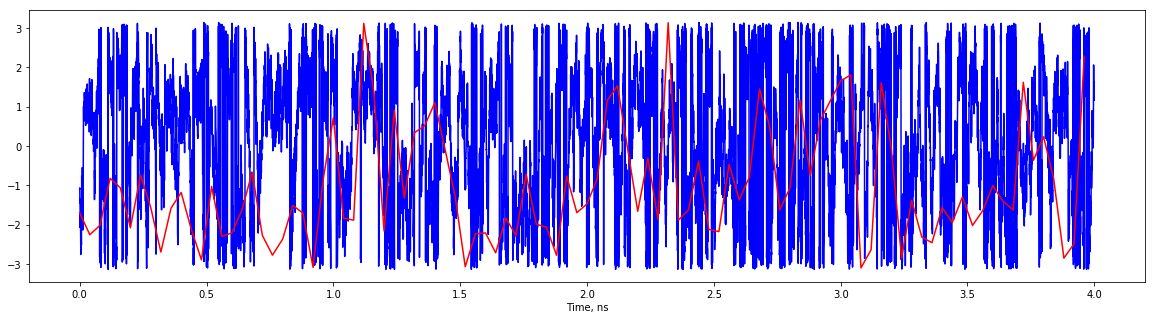

In [114]:
#Let's compare diffusion
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#Beginning of trj
plt.figure(figsize=(20,5))
d=plot_plumed('HILLS_t1_02_1_200_100ns.dat',plot=False)    
r=d[0:40000:4,1]
t=np.arange(0,100,0.0004)[0:10000]
plt.plot(t,r,'b-')
d2=plot_plumed('HILLS_t1_02_1_20000_10ns.dat',plot=False) 
r=d2[0:400:4,1]
t=np.arange(0,10,0.04)[0:100]
plt.plot(t,r,'r-')
plt.xlabel('Time, ns')

- We see a much slower diffusion.

### Simulating with a small perurbation 100 less than the original for 10 ns with 4 walkers: decreasing Gaussian height

We'll have to use 200 steps deposition rate, which is 0.4 ps. We will deposit  100000 gaussians in 25000 steps.

In [103]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=0.01 PACE=200 FILE=HILLS_t1_02_001_200_10ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
#The next line runs MD, takes a lot of time, and better should be run from a terminal, or even a Tmux terminal.
#!mpirun -np 4 mdrun_mpi -deffnm prod10ns_walkers -plumed plumed_walkers.dat -multi 4 #2> /dev/null 


Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


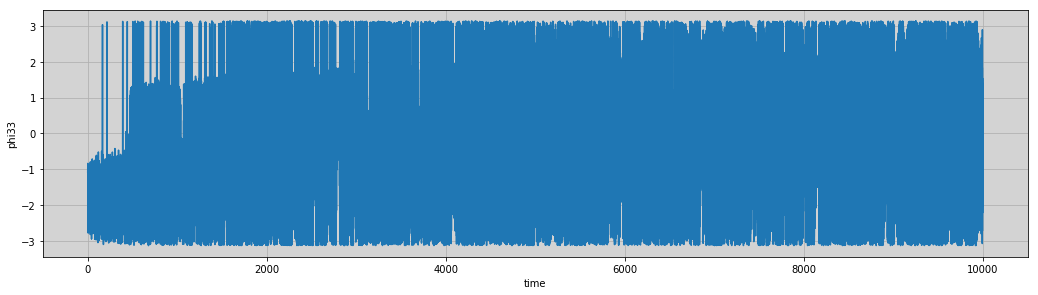

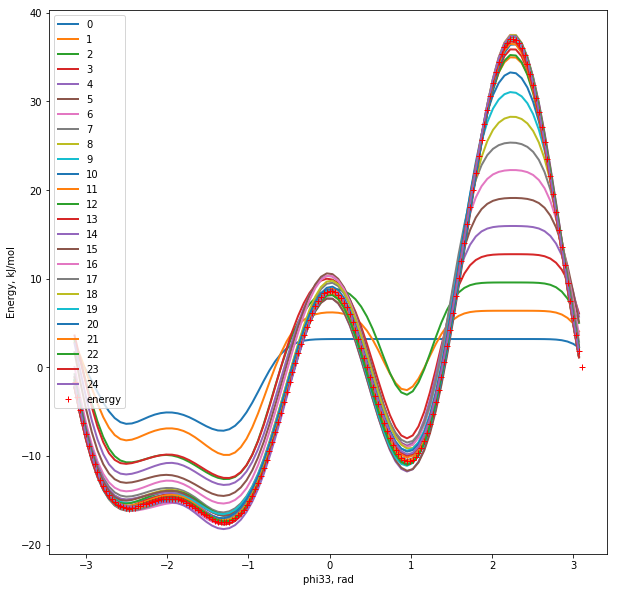

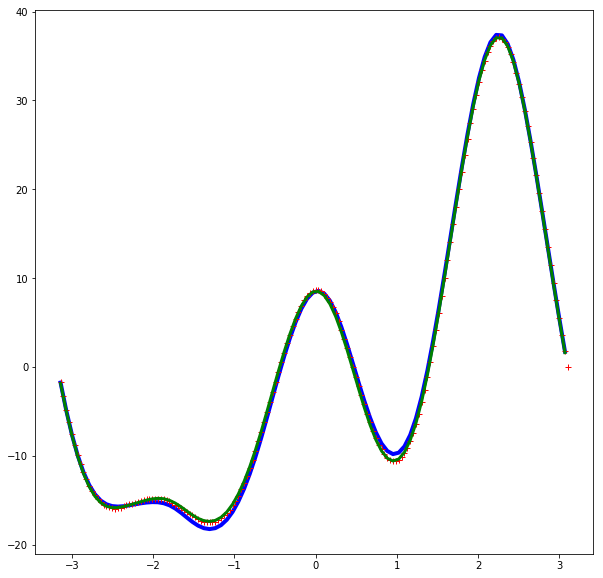

In [104]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!mkdir -p big_data
!plumed sum_hills --stride 4000  --hills HILLS_t1_02_001_200_10ns.dat --outfile big_data/sumhills_t1_02_001_200_10ns.dat --mintozero >/dev/null
d=plot_plumed('HILLS_t1_02_001_200_10ns.dat',figsize=(20,5),col2plot=[1]) 


sum_df=pd.DataFrame()


plt.figure(figsize=(10,10))
for i in range(25):
    data=plot_plumed('big_data/sumhills_t1_02_001_200_10ns.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
    plt.plot(df['angle'],df['energy'],label="%d"%i,linewidth=2)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=3)
# plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].min(),'r+',linewidth=4)


plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')
plt.figure(figsize=(10,10))
plt.plot(df['angle'],df['energy'],'b-',linewidth=4)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=4)

df_avr_n=sum_df.loc[sum_df['Time']>15].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n['angle'],df_avr_n['energy']-df_avr_n['energy'].mean(),'g-',linewidth=3)




Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']
Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


Text(0.5, 0, 'Time, ns')

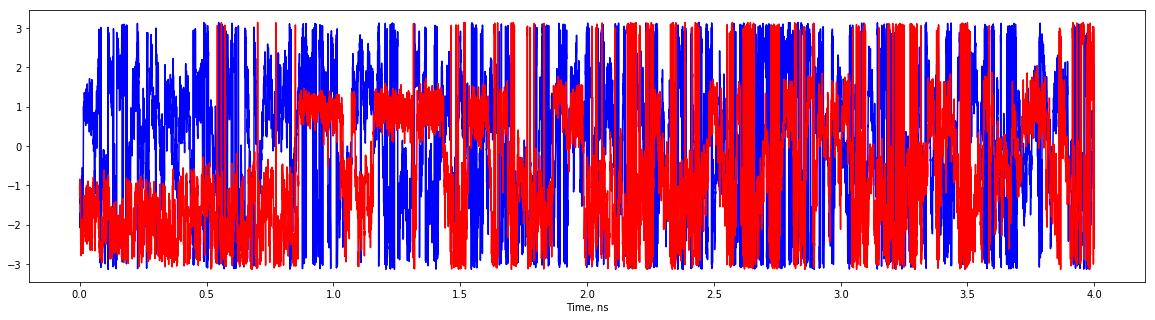

In [113]:
#Let's compare diffusion
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#Beginning of trj
plt.figure(figsize=(20,5))
d=plot_plumed('HILLS_t1_02_1_200_100ns.dat',plot=False)    
r=d[0:40000:4,1]
t=np.arange(0,100,0.0004)[0:10000]
plt.plot(t,r,'b-')
d2=plot_plumed('HILLS_t1_02_001_200_10ns.dat',plot=False) 
r=d2[0:40000:4,1]
t=np.arange(0,10,0.0004)[0:10000]
plt.plot(t,r,'r-')
plt.xlabel('Time, ns')

In [ ]:
#Let's compare diffusion
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#Beginning of trj
plt.figure(figsize=(20,5))
d=plot_plumed('HILLS_t1_02_1_200_100ns.dat',plot=False)    
r=d[0:40000:4,1]
t=np.arange(0,100,0.0004)[0:10000]
plt.plot(t,r,'b-')
d2=plot_plumed('HILLS_t1_02_001_200_10ns.dat',plot=False) 
r=d2[0:40000:4,1]
t=np.arange(0,10,0.0004)[0:10000]
plt.plot(t,r,'r-')
plt.xlabel('Time, ps')

The results are acutally better!
- Because we have better diffusion!

### Simulating with extreme perturbation 100 more than the original for 1 ns with 4 walkers: increasing depsotion rate

We'll have to use 2 steps deposition rate, which is 4 fs. We will deposit  1000 000 gaussians in 250 000 steps.

In [108]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=1 PACE=2 FILE=HILLS_t1_02_1_2_1ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
#The next line runs MD, takes a lot of time, and better should be run from a terminal, or even a Tmux terminal.
#!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 #2> /dev/null 


Last Frame read : 501, time : 1000.0 ps
501 frame read in 0.20 seconds


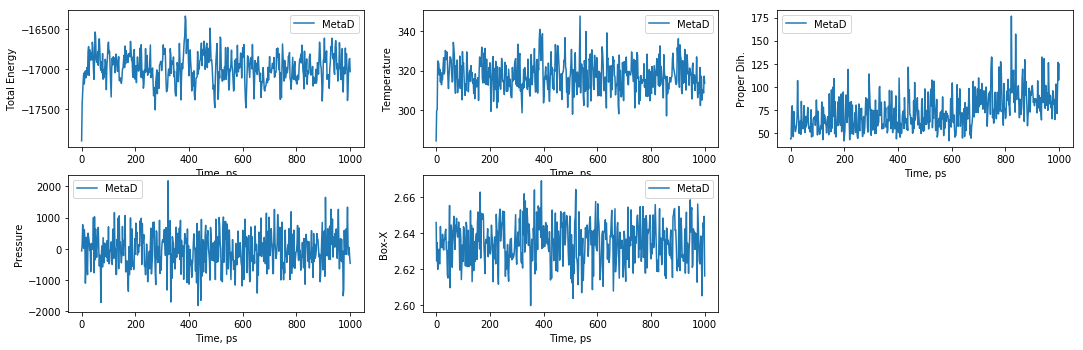

In [110]:
import panedr
df = panedr.edr_to_df('prod1ns_walkers0.edr', verbose=True)

num_of_keys=len(df.keys())
grid=[1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i,key in enumerate(['Total Energy','Temperature','Proper Dih.','Pressure','Box-X'],1):
    ax=plt.subplot(*grid, i)
    ax.plot(df[key],label='MetaD')
    ax.set_xlabel('Time, ps')
    ax.set_ylabel(key)
    ax.legend()    
plt.show()

We add 250 J (10 kT) per ps, but temperature is ok, although elevated to 320 from 300 !!! Which means we are not sampling at right temperature!!!

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


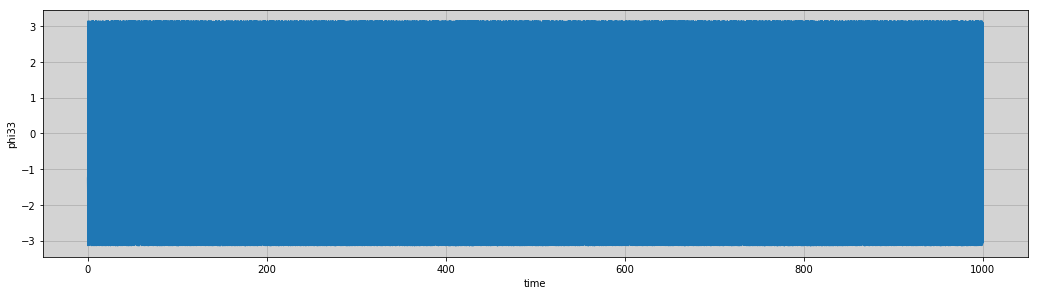

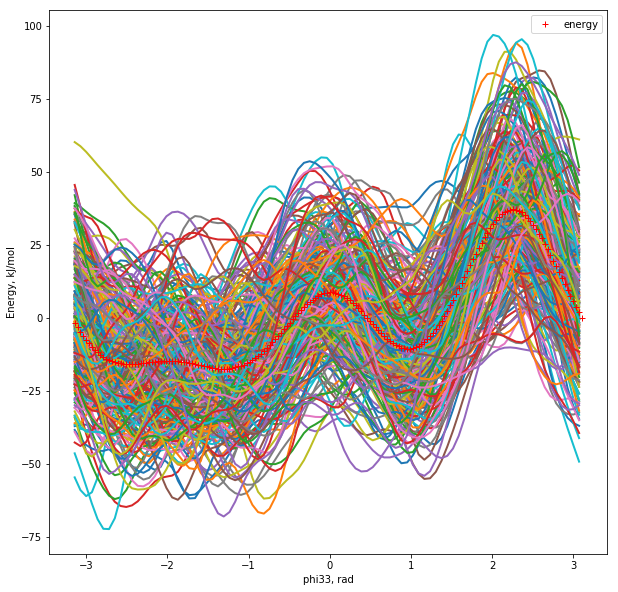

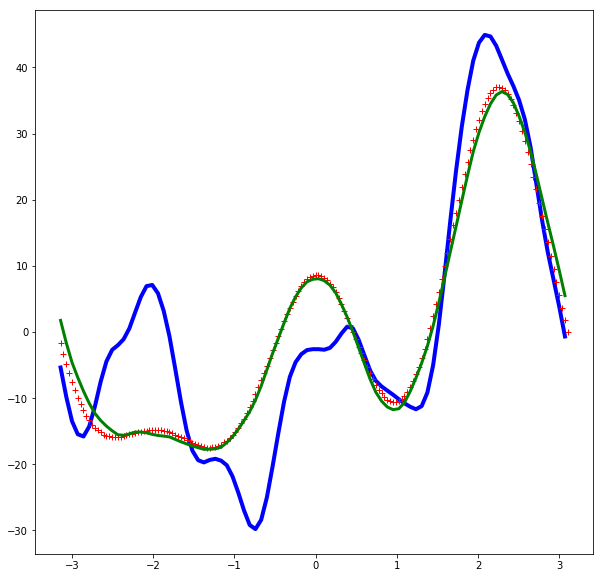

In [119]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!mkdir -p big_data
!plumed sum_hills --stride 4000  --hills HILLS_t1_02_1_2_1ns.dat --outfile big_data/sumhills_t1_02_1_2_1ns.dat --mintozero >/dev/null
d=plot_plumed('HILLS_t1_02_1_2_1ns.dat',figsize=(20,5),col2plot=[1]) 


sum_df=pd.DataFrame()


plt.figure(figsize=(10,10))
for i in range(250):
    data=plot_plumed('big_data/sumhills_t1_02_1_2_1ns.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
    plt.plot(df['angle'],df['energy'],linewidth=2,label='_nolegend_')
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=3)
# plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].min(),'r+',linewidth=4)


plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')
plt.figure(figsize=(10,10))
plt.plot(df['angle'],df['energy'],'b-',linewidth=4)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=4)

df_avr_n=sum_df.loc[sum_df['Time']>150].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n['angle'],df_avr_n['energy']-df_avr_n['energy'].mean(),'g-',linewidth=3)




Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']
Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


Text(0.5, 0, 'Time, ns')

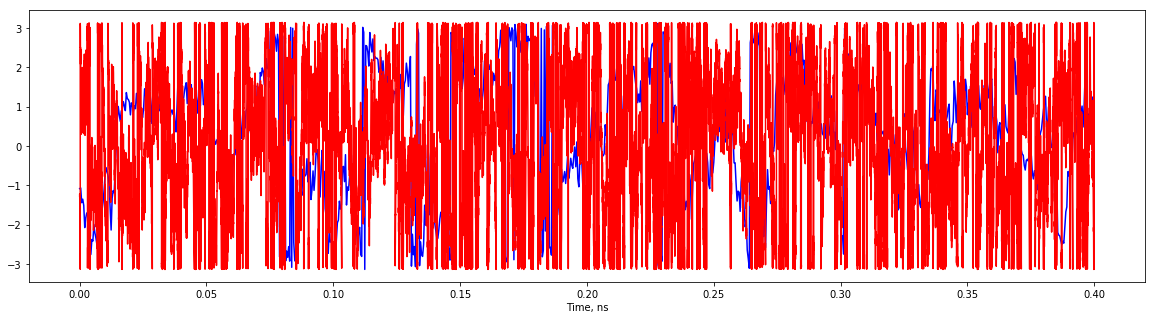

In [115]:
#Let's compare diffusion
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#Beginning of trj
plt.figure(figsize=(20,5))
d=plot_plumed('HILLS_t1_02_1_200_100ns.dat',plot=False)    
r=d[0:4000:4,1]
t=np.arange(0,100,0.0004)[0:1000]
plt.plot(t,r,'b-')
d2=plot_plumed('HILLS_t1_02_1_2_1ns.dat',plot=False) 
r=d2[0:400000:4,1]
t=np.arange(0,10,0.000004)[0:100000]
plt.plot(t,r,'r-')
plt.xlabel('Time, ns')

- Clearly this gives a very good diffusion rate.
- And FEP estimate is good too if averaged!

In [ ]:
- I assume if we increased the hill height by 100, the simulation would not be stable.

### Simulating with extreme perturbation 150 more than the original for 1 ns with 4 walkers: increasing depsotion rate, and hill height
400 times already gives segfault.
200 also gives segfault.
150 also gave segfault at 668 ps

We'll have to use 2 steps deposition rate, which is 4 fs. We will deposit  1000 000 gaussians in 250 000 steps.

In [129]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=1.5 PACE=2 FILE=HILLS_t1_02_15_2_1ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
#The next line runs MD, takes a lot of time, and better should be run from a terminal, or even a Tmux terminal.
#!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 #2> /dev/null 


Last Frame read : 335, time : 668.0 ps
335 frame read in 0.14 seconds


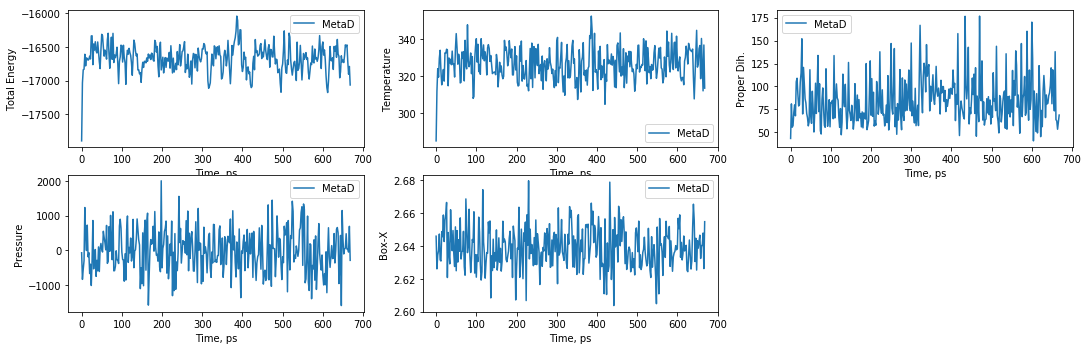

In [126]:
import panedr
df = panedr.edr_to_df('prod1ns_walkers0.edr', verbose=True)

num_of_keys=len(df.keys())
grid=[1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i,key in enumerate(['Total Energy','Temperature','Proper Dih.','Pressure','Box-X'],1):
    ax=plt.subplot(*grid, i)
    ax.plot(df[key],label='MetaD')
    ax.set_xlabel('Time, ps')
    ax.set_ylabel(key)
    ax.legend()    
plt.show()

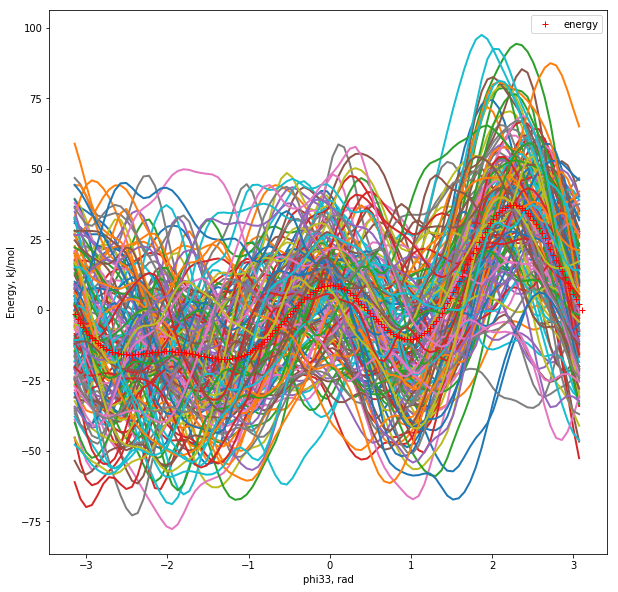

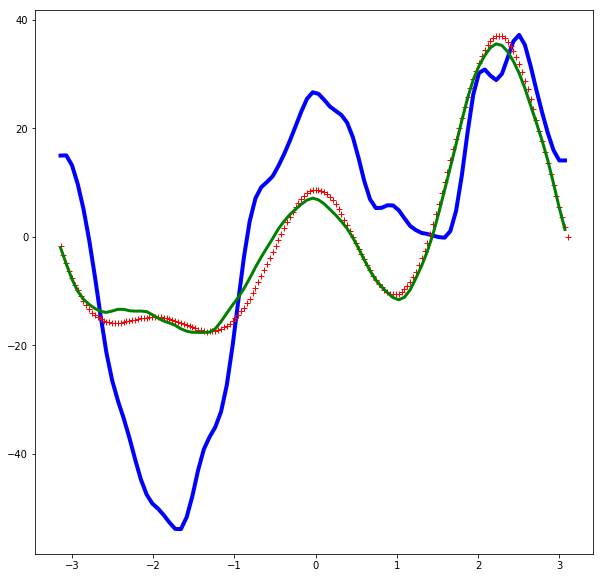

In [132]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!mkdir -p big_data
!plumed sum_hills --stride 4000  --hills HILLS_t1_02_15_2_1ns.dat --outfile big_data/sumhills_t1_02_15_2_1ns.dat --mintozero >/dev/null
#d=plot_plumed('HILLS_t1_02_15_2_1ns.dat',figsize=(20,5),col2plot=[1]) 


sum_df=pd.DataFrame()


plt.figure(figsize=(10,10))
for i in range(160):
    data=plot_plumed('big_data/sumhills_t1_02_15_2_1ns.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
    plt.plot(df['angle'],df['energy'],linewidth=2,label='_nolegend_')
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=3)
# plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].min(),'r+',linewidth=4)


plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')
plt.figure(figsize=(10,10))
plt.plot(df['angle'],df['energy'],'b-',linewidth=4)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=4)

df_avr_n=sum_df.loc[sum_df['Time']>10].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n['angle'],df_avr_n['energy']-df_avr_n['energy'].mean(),'g-',linewidth=3)




Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']
Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


Text(0.5, 0, 'Time, ns')

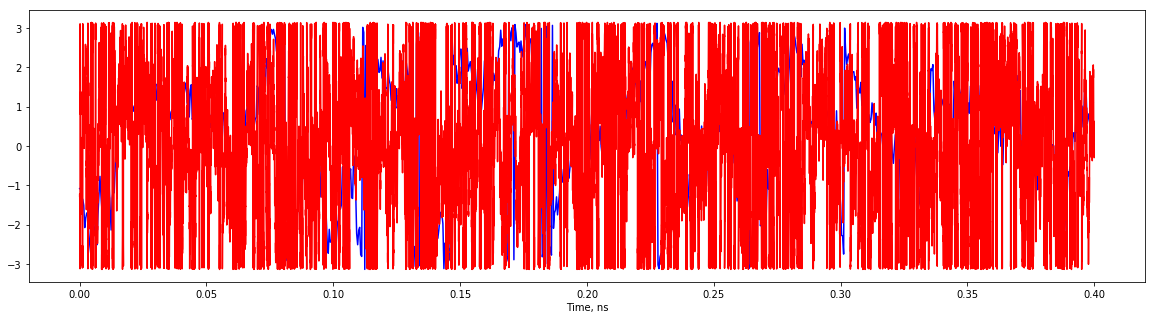

In [130]:
#Let's compare diffusion
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#Beginning of trj
plt.figure(figsize=(20,5))
d=plot_plumed('HILLS_t1_02_1_200_100ns.dat',plot=False)    
r=d[0:4000:4,1]
t=np.arange(0,100,0.0004)[0:1000]
plt.plot(t,r,'b-')
d2=plot_plumed('HILLS_t1_02_15_2_1ns.dat',plot=False) 
r=d2[0:400000:4,1]
t=np.arange(0,10,0.000004)[0:100000]
plt.plot(t,r,'r-')
plt.xlabel('Time, ns')

- We get even more diffusion
- But profile is still reasonable?!!

In [83]:
## Step 4. Recommendations on choosing parameters

In [133]:
# Auxilary
# Clear files
!rm \#*
!rm bck*
!rm sumhills*

rm: cannot remove 'sumhills*': No such file or directory


In [6]:
from importlib import reload
import funcs
reload(funcs)

<module 'funcs' from '/home/alexsha/projects/MolModEdu/PLUMED/funcs.py'>

## Step 5. A note on choosing CVs
From ref. https://onlinelibrary.wiley.com/doi/pdf/10.1002/wcms.31

Another instructive example can be found in Ref 26. Here, the authors wanted to study the penetra- tion of tetramethylammonium (TMA) into the acetyl- cholinesterase (AChE) gorge. In a first trial, only the distance between the center of mass of TMA and the active site of AChE was used as CV. This metadynam- ics run was not successful, as the system sometimes showed a diffusive behavior in the CV, whereas at other times, it got stuck at a particular point. This hysteretic behavior is the typical sign that a slow mo- tion of the system is not included in the CVs. As a result, the system remains stuck at a certain posi- tion until the rare event involving the hidden variable eventually takes place

By inspecting Figure trieste-4-metad-psi-phi-fig, we notice that something different happened compared to the previous exercise. At first the behavior of ψ looks diffusive in the entire CV space. However, around t=1 ns, ψ seems trapped in a region of the CV space in which it was previously diffusing without problems. The reason is that the non-biased CV ϕ after a while has jumped into a different local minima. Since ϕ is not directly biased, one has to wait for this (slow) degree of freedom to equilibrate before the free energy along ψ can converge.

Try to repeat the analysis done in the previous exercise, i.e. calculate the estimate of the free energy as a function of time, first step to assess the convergence of this metadynamics simulation.
